In [1]:
import os
import numpy as np
import pandas as pd
import pickle
import quandl
from datetime import datetime

import plotly.offline as py
import plotly.graph_objs as go
import plotly.figure_factory as ff
py.init_notebook_mode(connected=True)

In [2]:
# retrieve Bitcoin pricing data from Quandl API

def get_quandl_data(quandl_id):
       cache_path='{}.pkl'.format(quandl_id).replace('/','-')
       try:
              f=open(cache_path,'rb')
              df=pickle.load(f)
              print('Loaded {} from cache'.format(quandl_id))
       except (OSError,IOError) as e:
              print('Downloading {} from Quandl'.format(quandl_id))
              df=quandl.get(quandl_id,returns='pandas')
              df.to_pickle(cache_path)
              print('Cached {} at {}'.format(quandl_id,cache_path))
       return df

In [3]:
# We will pull data from Kraken bitcoin exchange
btc_eur_price_kraken=get_quandl_data('BCHARTS/KRAKENEUR')
# this creates and pickles the bitcoin exchange data from kraken in EUROS
# saves as a pandas dataframe

Cached BCHARTS/KRAKENEUR at BCHARTS-KRAKENEUR.pkl


In [4]:
btc_eur_price_kraken.tail()
btc_eur_price_kraken.columns
btc_eur_price_kraken.info()

btc_trace=go.Scatter(x=btc_eur_price_kraken.index,y=btc_eur_price_kraken['Weighted Price'])
py.iplot([btc_trace])


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1435 entries, 2014-01-08 to 2017-12-12
Data columns (total 7 columns):
Open                 1435 non-null float64
High                 1435 non-null float64
Low                  1435 non-null float64
Close                1435 non-null float64
Volume (BTC)         1435 non-null float64
Volume (Currency)    1435 non-null float64
Weighted Price       1435 non-null float64
dtypes: float64(7)
memory usage: 89.7 KB


In [6]:
# We will download data from 3 more BTC exchanges to get the aggregate Bitcoin price index
exchanges=['COINBASE','ITBIT']
exchange_data={}
exchange_data['KRAKEN']=btc_eur_price_kraken

for exchange in exchanges:
    exchange_code='BCHARTS/{}EUR'.format(exchange)
    btc_exchange_df=get_quandl_data(exchange_code)
    exchange_data[exchange]=btc_exchange_df

Loaded BCHARTS/COINBASEEUR from cache
Cached BCHARTS/ITBITEUR at BCHARTS-ITBITEUR.pkl


In [8]:
# Merge pricing data from all exchanges into a single dataframe
def merge_dfs_on_column(dataframes,labels,col):
    series_dict={}
    for index in range(len(dataframes)):
        series_dict[labels[index]]=dataframes[index][col]
    return pd.DataFrame(series_dict)

In [9]:
btc_eur_datasets=merge_dfs_on_column(list(exchange_data.values()),list(exchange_data.keys()),'Weighted Price')

In [10]:
btc_eur_datasets.tail()

,COINBASE,ITBIT,KRAKEN
Date,,,
2017-12-08,13773.163670,12991.202441,12916.879888
2017-12-09,12689.575290,12188.461254,12145.907159
2017-12-10,12691.146977,12467.889880,12045.624554
2017-12-11,14136.705472,14160.797071,13653.258709
2017-12-12,13889.516846,NaN,13650.850371


In [12]:
btc_eur_datasets.isnull().sum()

COINBASE    663
ITBIT         1
KRAKEN       52
dtype: int64

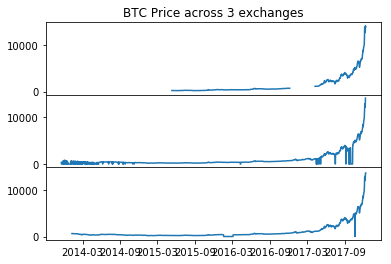

In [19]:
import matplotlib.pyplot as plt
% matplotlib inline
f,(ax1,ax2,ax3)=plt.subplots(3,sharex=True,sharey=True)
ax1.plot(btc_eur_datasets['COINBASE'])
ax1.set_title('BTC Price across 3 exchanges')
ax2.plot(btc_eur_datasets['ITBIT'])
ax3.plot(btc_eur_datasets['KRAKEN'])
f.subplots_adjust(hspace=0)

In [22]:
# Plotly Helper function to generate scatter plot of the entire dataframe
def df_scatter(df,title,separate_y_axis=False,y_axis_label='',scale='linear',initial_hide=False):
    label_arr=list(df)
    series_arr=list(map(lambda col:df[col],label_arr))
    layout=go.Layout(title=title,legend=dict(orientation='h'),xaxis=dict(type='date'),yaxis=dict(title=y_axis_label,showticklabels=not separate_y_axis,
                                                                                                type=scale))
    y_axis_config=dict(overlaying='y',
                      showticklabels=not separate_y_axis,
                      type=scale)
    visibility='visible'
    if initial_hide:
        visibility='legendonly'
        
        # form trace for each series
    trace_arr=[]
    for index,series in enumerate(series_arr):
            trace=go.Scatter(
            x=series.index,
            y=series,
            name=label_arr[index],
            visible=visibility)
            
            # Add separate axis for the series
            if separate_y_axis:
                trace['yaxis']='y{}'.format(index+1)
                layout['yaxis{}'.format(indedx+1)]=y_axis_config
            trace_arr.append(trace)
            
    fig=go.Figure(data=trace_arr,layout=layout)
    py.iplot(fig)
    

In [23]:
df_scatter(btc_eur_datasets,'BTC Price(EUR)')

In [25]:
# Remove 0 values in the dataset as the price has never been 0
btc_eur_datasets.replace(0,np.nan,inplace=True)

In [26]:
df_scatter(btc_eur_datasets,'BTC price in EUR')

In [27]:
# Average BTC price across the exchanges as a new column
btc_eur_datasets['Average_BTC_price']=btc_eur_datasets.mean(axis=1)
btc_eur_datasets['Average_BTC_price'].head()

Date
2013-11-17    345.0
2013-11-18      NaN
2013-11-19      NaN
2013-11-20      NaN
2013-11-21      NaN
Freq: D, Name: Average_BTC_price, dtype: float64

In [30]:
# Let us Plot the average BTC price
btc_trace=go.Scatter(x=btc_eur_datasets.index,y=btc_eur_datasets['Average_BTC_price'])
py.iplot([btc_trace])

In [31]:
# Get Altcoin Pricing data
# We will use the Poloniex API
# the data will be received in the form of JSON which we will return as a dataframe
'''def get_json_data(json_url,cache_path):
    try:
        f=open(cache_path,'rb')
        df=pickle.load(f)
        print('Loaded {} from cache'.format(json_url))
    except (OSError,IOError) as e:
        print('Downloading {}'.format(json_url))
        df=pd.read_json(json_url)
        df.to_pickle(cache_path)
        print('Cached {} at {}'.format(json_url,cache_path))
    return df'''

In [40]:
'''base_polo_url='https://poloniex.com/public?command=returnChartData&currencyPair={}&start={}&end={}&period={}'
start_date=datetime.strptime('2015-01-01','%Y-%m-%d')
end_date=datetime.now()
period=86400

def get_crypto_data(poloniex_pair):
    json_url=base_polo_url.format(poloniex_pair,start_date.timestamp(),end_date.timestamp(),period)
    data_df=get_json_data(json_url,poloniex_pair)
    data_df=data_df.set_index('date')
    return data_df'''

In [43]:
'''altcoins=['ETH','LTC','XMR','XRP','ZEC','DASH','SC']

altcoin_data={}
for altcoin in altcoins:
    coinpair='BTC_{}'.format(altcoin)
    crypto_price_df=get_crypto_data(coinpair)
    altcoin_data[altcoin]=crypto_price_df'''
    
# poloniex not working. IP is flagged with restriction. Courtesy of CloudFlare
# 2 options: download the data via the links in JSON format and then convert them dataframes
# Try some other exchange API

# Let us download the JSON format and treat it and add it here.
# JSON files have been downloaded now lets add them here and convert them into dataframes


"altcoins=['ETH','LTC','XMR','XRP','ZEC','DASH','SC']\n\naltcoin_data={}\nfor altcoin in altcoins:\n    coinpair='BTC_{}'.format(altcoin)\n    crypto_price_df=get_crypto_data(coinpair)\n    altcoin_data[altcoin]=crypto_price_df"

In [44]:
altcoins=['ETH','LTC','XMR','XRP','ZEC','DASH','SC']
altcoin_data={}
for altcoin in altcoins:
    _=pd.read_json('D:\Red Bull Prep\Cryptocurrency analysis\BTC_{}.json'.format(altcoin))
    _=_.set_index('date')
    altcoin_data[altcoin]=_
    

In [47]:
altcoin_data['ETH'].tail()

,close,high,low,open,quoteVolume,volume,weightedAverage
date,,,,,,,
2017-12-08,0.027759,0.031700,0.023700,0.024883,479875.396362,13334.945566,0.027788
2017-12-09,0.031287,0.034813,0.027500,0.027880,283221.439621,8972.838448,0.031681
2017-12-10,0.028639,0.032980,0.027783,0.031304,206010.640374,6245.219863,0.030315
2017-12-11,0.030700,0.031085,0.026823,0.028636,191132.922060,5433.180530,0.028426
2017-12-12,0.032385,0.033448,0.029710,0.030710,156561.697659,4930.997665,0.031496


In [48]:
# Putting the Prices in EUR
for altcoin in altcoin_data.keys():
    altcoin_data[altcoin]['price_EUR']=altcoin_data[altcoin]['weightedAverage']*btc_eur_datasets['Average_BTC_price']

In [49]:
altcoin_data['ETH']['price_EUR'].tail()

date
2017-12-08    367.558784
2017-12-09    390.989506
2017-12-10    375.953476
2017-12-11    397.499963
2017-12-12    433.699506
Name: price_EUR, dtype: float64

In [51]:
combined_df=merge_dfs_on_column(list(altcoin_data.values()),list(altcoin_data.keys()),'price_EUR')
combined_df['BTC']=btc_eur_datasets['Average_BTC_price']
combined_df.head()

,DASH,ETH,LTC,SC,XMR,XRP,ZEC,BTC
date,,,,,,,,
2015-01-01,1.635045,NaN,2.240262,NaN,0.371214,0.019838,NaN,261.755952
2015-01-02,1.641534,NaN,2.232803,NaN,0.379138,0.020380,NaN,262.560968
2015-01-03,1.517972,NaN,1.995038,NaN,0.395689,0.018615,NaN,251.720427
2015-01-04,1.422133,NaN,1.734066,NaN,0.354209,0.015843,NaN,230.741731
2015-01-05,1.382458,NaN,1.739568,NaN,0.346695,0.016793,NaN,227.091071


In [53]:
df_scatter(combined_df,'CryptoCurrency Prices in EUR',separate_y_axis=False,y_axis_label='Coin Value(EUR)',scale='log')

In [54]:
# Let us view the Pearson Correlation Coefficients for 2017
combined_df_2017=combined_df[combined_df.index.year==2017]
combined_df_2017.pct_change().corr(method='pearson')

,DASH,ETH,LTC,SC,XMR,XRP,ZEC,BTC
DASH,1.000000,0.481634,0.291207,0.224717,0.451676,0.093458,0.510191,0.283688
ETH,0.481634,1.000000,0.373413,0.361760,0.531050,0.187932,0.509438,0.391714
LTC,0.291207,0.373413,1.000000,0.326382,0.408678,0.350544,0.220419,0.385746
SC,0.224717,0.361760,0.326382,1.000000,0.333765,0.261665,0.227628,0.325282
XMR,0.451676,0.531050,0.408678,0.333765,1.000000,0.249431,0.421964,0.387598
XRP,0.093458,0.187932,0.350544,0.261665,0.249431,1.000000,0.202032,0.194690
ZEC,0.510191,0.509438,0.220419,0.227628,0.421964,0.202032,1.000000,0.274684
BTC,0.283688,0.391714,0.385746,0.325282,0.387598,0.194690,0.274684,1.000000


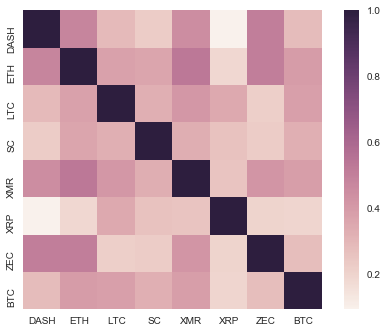

In [56]:
# We can create a correlation heatmap using seaborn
import seaborn as sns
corr=combined_df_2017.pct_change().corr(method='pearson')
sns.heatmap(corr,square=True)


In [ ]:
# More to come soon